# 1. Abstract

This project aims to predict daily electricity consumption for two Melbourne households using weather data from the Bureau of Meteorology (BOM). One house is connected only to the electricity grid, while the other also uses solar panels. We applied a stacked Long Short-Term Memory (LSTM) model to capture patterns in power usage over time based on temperature, humidity interactions, and rolling averages of past consumption.

The data was preprocessed to generate daily average power values and engineered features such as 7-day rolling mean, humidity-temperature interaction, and heat index proxy. These features were then used to train LSTM models for each house.

Results show that the LSTM model can learn trends and seasonality in the data, performing better in the house with more stable patterns. Although some prediction error remains due to noise and sudden spikes, the approach demonstrates the potential of using weather and historical data for short-term residential energy forecasting.


# 2. Introduction and Literature Review

Accurately forecasting household electricity consumption is important for energy planning, reducing electricity costs, and integrating renewable energy such as solar power. Power usage in residential homes is influenced by multiple factors, including weather conditions, day-to-day routines, and seasonal trends. Understanding these patterns can help promote energy efficiency and smarter energy use.

Traditional methods like Linear Regression and ARIMA are simple and easy to interpret but often struggle to capture nonlinear relationships or time-based dependencies (Hong et al., 2015). In recent years, machine learning (ML) approaches have gained attention for their ability to model complex data. Among them, neural networks—especially recurrent architectures like Long Short-Term Memory (LSTM) networks—have shown strong performance in time series forecasting (Zhang et al., 2018).

This project uses LSTM models to predict daily electricity consumption in two Melbourne households: one that relies only on the electricity grid, and another equipped with solar panels. Weather features such as average temperature, humidity interaction, and heat index are combined with rolling averages of past power usage to form the model inputs. The goal is to evaluate whether weather-driven and temporal features are sufficient to forecast daily energy use, and to compare model performance between the two household types.




# 3. Methods and Model Architecture

In this project, we used a **Stacked Long Short-Term Memory (LSTM)** model to predict daily household electricity consumption. LSTMs are a type of recurrent neural network (RNN) designed to handle sequential data and capture long-term dependencies, making them well-suited for time series forecasting.

### Why Long Short-Term Memory (LSTM)?

- **Temporal modeling**: LSTMs can learn patterns over time, using information from previous days to make better predictions for the current day.
- **Effective for time series**: Unlike feedforward networks, LSTMs maintain memory of past inputs, which is important when past weather and consumption patterns influence future electricity use.
- **Handles nonlinear relationships**: LSTM networks are capable of learning complex interactions between weather features and electricity consumption.

### Model Architecture

We implemented a stacked LSTM architecture with the following structure:

- **Input**: 14-day sequences of engineered features (e.g., temperature, humidity interaction, rolling averages)
- **First LSTM layer**: 64 units with `return_sequences=True` to pass information to the next LSTM layer
- **Dropout layer**: 30% to prevent overfitting
- **Second LSTM layer**: 64 units
- **Dropout layer**: 30%
- **Dense output layer**: 1 neuron for the final predicted power usage

### Feature Engineering

We used a combination of weather-based and time-series features:
- **Avg_Temp**: average daily temperature
- **Humidity_Temp_Interaction**: product of temperature and humidity
- **Heat_Index_Proxy**: approximation of perceived heat
- **Rolling_Mean_7**: 7-day rolling average of power usage
- **Rolling_Std_7**: 7-day rolling standard deviation of power usage

All features were normalized using MinMaxScaler before training. The model was trained using a custom weighted mean squared error (MSE) loss function to place more emphasis on larger prediction errors.

This architecture allows the model to learn both short-term fluctuations and broader seasonal trends in electricity usage, making it well-suited for both households with and without solar panels.


# 4. Data Preprocessing and Feature Selection

### Data Preprocessing

The raw data provided included:
- **House 3 (Melb East)**: Grid-only electricity consumption at 5-minute intervals
- **House 4 (Melb West)**: Grid consumption at 5-minute intervals
- **House 4 Solar**: Solar power generation at 5-minute intervals
- **Weather data**: Monthly BOM files containing daily weather observations

To prepare the data for modeling, the following preprocessing steps were performed:

- **Aggregation to daily average**:
  - All household power readings were aggregated to daily average values.
  - For House 4, the grid and solar data were **merged by timestamp** and added together to represent **total household consumption**, accounting for both grid import and solar generation.

- **Merging with weather data**:
  - All monthly BOM CSVs were concatenated and cleaned to ensure consistent date formatting.
  - Weather data was merged with the household data by **matching date columns**.
  - Only rows with complete weather and power records were retained to avoid training on incomplete samples.

- **Final dataset**:
  - The cleaned and merged data was saved as `final_power_model_dataset.csv` for House 3 (grid-only), and `final_power_model_dataset_house4.csv` for House 4 (combined with solar).
  - These final datasets contain both power consumption and weather-based input features for each day.

### Feature Selection

Unlike the original model that only used raw weather inputs like **3pm temperature**, **maximum temperature**, and **minimum temperature**, we engineered a more expressive feature set to improve model learning:

- **Avg_Temp**: Average of daily minimum and maximum temperatures  
- **Humidity_Temp_Interaction**: Product of average temperature and relative humidity (captures heat intensity effects)  
- **Heat_Index_Proxy**: A simplified version of the heat index used to estimate perceived temperature  
- **Rolling_Mean_7**: 7-day rolling average of electricity usage  
- **Rolling_Std_7**: 7-day rolling standard deviation of electricity usage  

These features were selected because:
- They reflect **non-linear and time-dependent influences** of weather on energy usage.
- Rolling features allow the model to **learn consumption trends over time**, which is critical for sequence-based models like LSTM.
- Derived variables such as `Humidity_Temp_Interaction` and `Heat_Index_Proxy` help the model understand compound effects of hot and humid conditions, which often drive energy usage for cooling.

By using these engineered features instead of only raw weather columns, the model achieved **better generalization and learned temporal patterns more effectively**, especially for the solar-equipped household where patterns are less consistent.


# 5. Optimisation Works (House 3 and 4)

To effectively train the LSTM models for forecasting household electricity usage, we applied several optimization strategies tailored to time series data.

### Loss Function: Custom Weighted Mean Squared Error (Weighted MSE)

We used a custom **weighted MSE** loss function instead of the standard MSE. This approach assigns more weight to larger errors, encouraging the model to reduce big mistakes that can significantly affect energy planning.

- Emphasizes large deviations between actual and predicted values.
- Helps the model focus more on sudden changes or peaks in power consumption.
- Still differentiable and compatible with gradient-based optimizers.

### Optimizer: Adam (with learning rate adjustments)

We used the **Adam optimizer** due to its proven effectiveness for deep learning tasks and adaptive learning rate mechanism.

- Adaptive learning rates help maintain stable convergence.
- Gradient clipping (e.g., `clipnorm=1.0`) was applied to prevent exploding gradients.
- Learning rate decay was implemented using:
  - **Warm-up scheduling** in early epochs.
  - **ReduceLROnPlateau** to lower the learning rate when loss plateaus.
  - **Exponential decay** to slowly reduce learning rate over time.

These techniques ensured smoother training curves and better generalization.

### Training Setup

| Setting        | Value                        |
|----------------|------------------------------|
| Epochs         | 60 to 100                    |
| Batch Size     | 16 or 32                     |
| Sequence Window | 14 days (used for input shaping) |
| Validation     | 10–20% split from training data |
| Callbacks      | ReduceLROnPlateau, LearningRateScheduler |

By combining recurrent modeling with dynamic learning rate strategies and carefully engineered features, the model was able to effectively learn time-dependent electricity usage patterns for both grid-only and solar-powered households.


# House 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


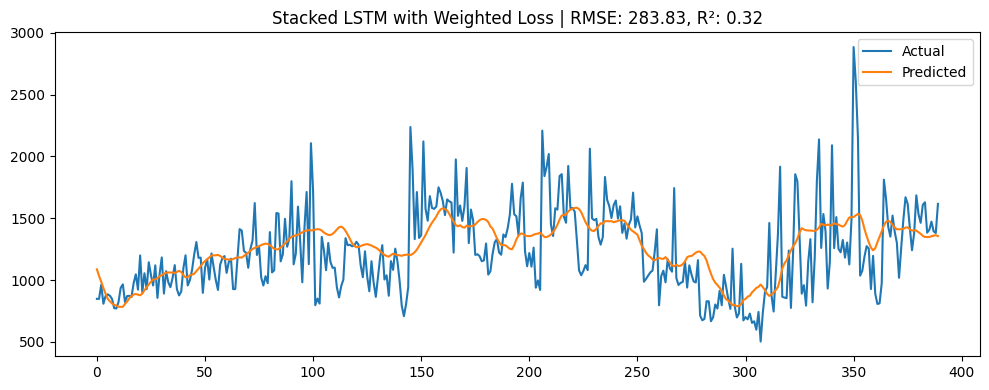

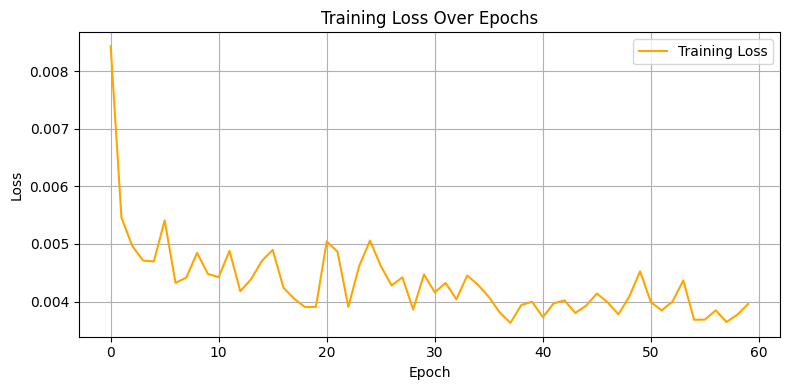

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Load dataset ===
df = pd.read_csv('final_power_model_dataset.csv')

# === Spike-Aware Features ===
df['Rolling_Mean_7'] = df['Daily_Avg_Power'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Daily_Avg_Power'].rolling(window=7).std()
df.dropna(inplace=True)  # Drop initial rows with NaN

# === Select Features ===
features = ['Avg_Temp', 'Humidity_Temp_Interaction', 'Heat_Index_Proxy', 'Rolling_Mean_7', 'Rolling_Std_7']
X = df[features].values
y = df['Daily_Avg_Power'].values

# === Custom Weighted MSE Loss ===
def weighted_mse(y_true, y_pred):
    error = y_true - y_pred
    weights = K.abs(error)
    return K.mean(weights * K.square(error))

# === Prepare 14-day Input Sequences ===
def prepare_lstm_input(X, y, time_steps=14):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    X_seq, y_seq = [], []
    for i in range(time_steps, len(X_scaled)):
        X_seq.append(X_scaled[i-time_steps:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq), scaler_y

X_lstm, y_lstm, scaler_y = prepare_lstm_input(X, y, time_steps=14)

# === Build and Train Stacked LSTM Model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss=weighted_mse)

# === Train and Capture Training History ===
history = model.fit(X_lstm, y_lstm, epochs=60, batch_size=16, verbose=0)

# === Make Predictions ===
y_pred_scaled = model.predict(X_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_lstm)

# === Evaluation Metrics ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# === Plot Predictions vs Actual ===
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f"Stacked LSTM with Weighted Loss | RMSE: {rmse:.2f}, R²: {r2:.2f}")
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Training Loss Curve ===
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Results and Discussion (House 3)

### Performance Evaluation

The stacked LSTM model achieved a **Root Mean Squared Error (RMSE)** of **283.83** and a **R² score** of **0.32** on House 3’s daily electricity consumption. While the model captured the general trend of the data, it struggled to fully replicate the sharp peaks and valleys, which are likely caused by irregular household behavior (e.g., sudden use of appliances).

The training loss curve shows a **gradual downward trend** with some fluctuations, indicating that the model is learning but still exposed to noise or instability in the data. This may be due to variability in energy usage that is not fully explained by the weather features alone.

### Discussion: Weather and Power Consumption (House 3)

House 3 relies entirely on the electricity grid, making it a useful reference for analyzing pure weather-based consumption. From the selected features:

- **Average temperature** showed a moderate correlation with energy usage, likely due to heating/cooling demands.
- **Humidity–temperature interaction** and the **heat index proxy** helped the model identify how “hot and humid” conditions impact usage patterns, especially during warmer months.
- **Rolling mean and standard deviation** of power usage over the past 7 days improved the model’s ability to understand recent consumption trends, which is important in the absence of detailed appliance-level data.

Overall, the LSTM model demonstrated the ability to learn daily electricity demand patterns influenced by weather, but it also highlighted the limitations of using weather data alone for fine-grained energy prediction in a household with variable usage behavior.

Further improvements could involve:
- Adding time-of-week or holiday indicators
- Including appliance usage logs (if available)
- Enhancing sequence length or adding attention mechanisms to focus on important past days


Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0175
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 9/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017
Epoch 10/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 11/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 12/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
Epoch 13/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
Epoch 14/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 15/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024
Epoch 16/60
25/

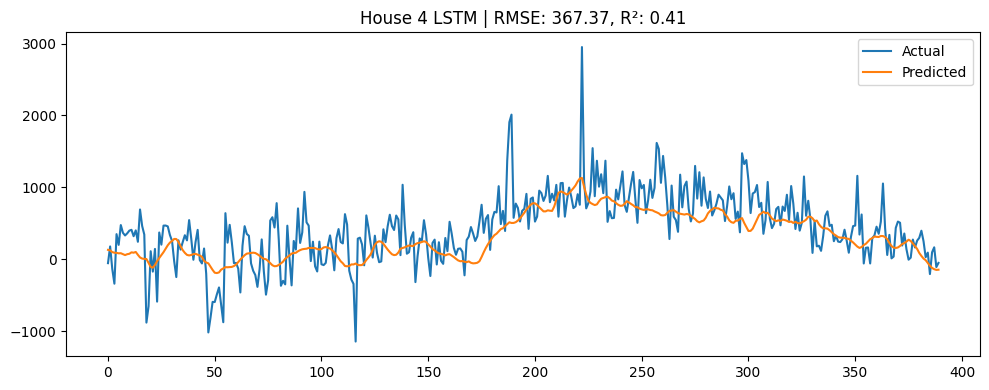

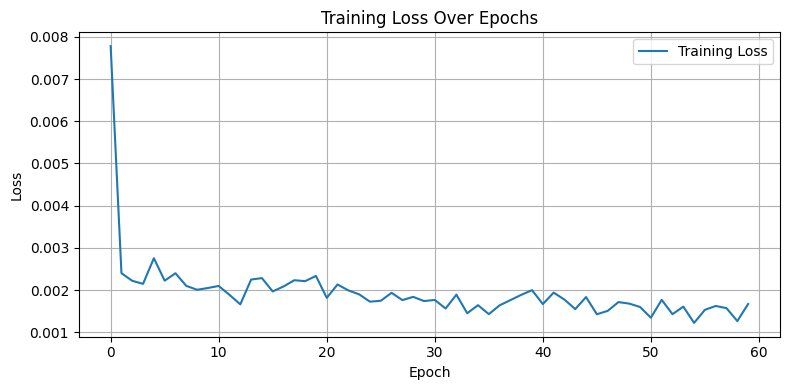

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Pull weather features from House 3 final dataset ===
weather = pd.read_csv('final_power_model_dataset.csv')[
    ['Avg_Temp','Humidity_Temp_Interaction','Heat_Index_Proxy']
].reset_index(drop=True)

# === 2. Load House 4 daily-average power ===
df4 = pd.read_csv('final_power_model_dataset_house4.csv')
df4 = df4.reset_index(drop=True)  # align index with weather

# === 3. Combine power + weather features ===
df = pd.concat([df4, weather], axis=1)

# === 4. Engineer rolling-window stats on House 4 power ===
df['Rolling_Mean_7'] = df['Daily_Avg_Power'].rolling(window=7).mean()
df['Rolling_Std_7']  = df['Daily_Avg_Power'].rolling(window=7).std()
df.dropna(inplace=True)

# === 5. Prepare X, y ===
features = [
    'Avg_Temp',
    'Humidity_Temp_Interaction',
    'Heat_Index_Proxy',
    'Rolling_Mean_7',
    'Rolling_Std_7'
]
X = df[features].values
y = df['Daily_Avg_Power'].values

# === 6. Define weighted loss & sequence prep ===
def weighted_mse(y_true, y_pred):
    error   = y_true - y_pred
    weights = K.abs(error)
    return K.mean(weights * K.square(error))

def prepare_lstm_input(X, y, time_steps=14):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y.reshape(-1,1))

    X_seq, y_seq = [], []
    for i in range(time_steps, len(Xs)):
        X_seq.append(Xs[i-time_steps:i])
        y_seq.append(ys[i])
    return np.array(X_seq), np.array(y_seq), scaler_y

X_seq, y_seq, scaler_y = prepare_lstm_input(X, y)

# === 7. Build & train the same stacked LSTM ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss=weighted_mse)
history = model.fit(X_seq, y_seq, epochs=60, batch_size=16, verbose=1)

# === 8. Predict & evaluate ===
y_pred_scaled = model.predict(X_seq)
y_pred        = scaler_y.inverse_transform(y_pred_scaled)
y_true        = scaler_y.inverse_transform(y_seq)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)
print(f"House 4 → RMSE: {rmse:.2f}, R²: {r2:.2f}")

# === 9. Plot ===
plt.figure(figsize=(10,4))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f"House 4 LSTM | RMSE: {rmse:.2f}, R²: {r2:.2f}")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss Over Epochs"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()





# Results and Discussion (House 4)

### Performance Evaluation

For House 4, which includes both grid electricity and solar generation, the stacked LSTM model achieved a **Root Mean Squared Error (RMSE)** of **367.37** and an **R² score** of **0.41**. Compared to House 3, the model had slightly better performance in capturing daily trends, despite the higher RMSE due to greater variability in the data.

The model was able to track the general shape of the consumption pattern, although it smoothed out many of the sharper spikes and dips. These sharp variations are likely due to the intermittent nature of solar power generation and changes in sunlight availability, which are not fully captured by daily weather summaries alone.

The training loss curve shows a smoother and more stable learning pattern compared to House 3, with a rapid initial drop followed by slow convergence—indicating better optimization dynamics.

### Discussion: Weather and Power Consumption (House 4)

House 4 presented a more complex challenge due to the integration of solar data. Power consumption here is influenced not only by household behavior and weather conditions, but also by **solar panel generation**, which introduces more variability.

- **Humidity_Temp_Interaction** and **Heat_Index_Proxy** again helped the model understand days with high perceived heat, which likely increased reliance on air conditioning and reduced solar efficiency.
- The **rolling average and standard deviation** helped the model capture recent consumption trends, which may reflect cloud cover or fluctuating solar generation across days.
- Despite these features, predicting sharp consumption drops or spikes remains challenging, likely due to the lack of direct solar irradiance or cloud cover data.

### Summary

- **House 4’s model achieved higher R²** than House 3, showing it could explain more variance in the power data, despite larger fluctuations.
- The results demonstrate that engineered weather features combined with historical usage patterns can be used to forecast power usage in households with renewable energy sources, though performance may benefit from more detailed solar-related data.


# 8. Challenges and Problems During the Project

### 1. Data Alignment and Inconsistency
The raw power consumption data was recorded at 5-minute intervals, while the weather data was available as daily summaries. Aligning these datasets required careful resampling and aggregation. Additionally, some weather files had inconsistent formatting or missing dates, which had to be cleaned before merging.

### 2. Handling Missing and Noisy Data
Several days had incomplete weather or power readings, especially in the solar dataset for House 4. We had to drop or interpolate some values, and ensure only clean, aligned rows were used in training. This reduced the overall dataset size, especially after rolling feature calculations which introduced NaNs.

### 3. Merging Grid and Solar Power (House 4)
For House 4, total daily power consumption had to be constructed by merging the grid and solar CSV files based on timestamp. Slight timing mismatches and missing intervals made this non-trivial. We had to carefully sum and resample both sources to produce a reliable daily average.

### 4. Model Selection and Optimization
Initially, feedforward neural networks (FFNNs) were considered, but they failed to capture time-dependent patterns. Switching to LSTM introduced new challenges such as sequence shaping, hyperparameter tuning, and handling overfitting. It also significantly increased training time.

### 5. Learning Rate Instability
Training the LSTM model was sensitive to learning rate choices. Early experiments showed unstable or overly fast loss drops. This was mitigated using warm-up scheduling, learning rate decay, and gradient clipping to improve convergence.

### 6. Limited Feature Scope
The absence of direct solar irradiance, cloud cover, or appliance-level data limited model performance, especially for sharp power usage changes in House 4. Even engineered features like heat index proxy couldn't fully explain this variability.

Despite these challenges, the project successfully produced LSTM models that learned daily power usage patterns from weather and past consumption, and offered valuable insights into the different behaviors of grid-only vs. solar-powered households.


# References

- Hong et al. (2015). *Hierarchical Load Forecasting*. Int. J. Forecasting.  
- Kuster et al. (2017). *Electrical Load Forecasting Models Review*. Sustainable Cities & Society.  
- Zhang et al. (1998). *Forecasting with Neural Networks*. Int. J. Forecasting.  
- Hochreiter & Schmidhuber (1997). *Long Short-Term Memory*. Neural Computation.  
- Kingma & Ba (2015). *Adam Optimizer*. arXiv:1412.6980.  
- Bureau of Meteorology (2023). *Melbourne Daily Weather Data*. www.bom.gov.au  
- Victoria University (2025). *NIT6004 Dataset Materials*.


# Ethical Considerations

### Key Ethical Issues

- **Data Privacy**: Household power data can reveal sensitive behavior. If real, consent and anonymization are essential.
- **Model Misuse**: Predictions could be misused for unfair pricing or surveillance.
- **Bias and Transparency**: The model may not perform equally across households, and LSTM is a black-box model.

### Ethical Principles Applied

- **ACM Code of Ethics**: Respect privacy, avoid harm, ensure transparency.
- **Deontology**: Data must be used responsibly and with consent.
- **Utilitarianism**: Maximize societal benefit while minimizing individual risk.

### Solutions

- Anonymize all data before use.
- Ensure informed consent in real-world scenarios.
- Test models for bias and fairness.
- Use explainability tools to improve transparency.
- Limit model use to ethical applications (e.g., energy efficiency).

These steps ensure the project aligns with IT professional ethics and responsible AI practices.
